# Ensemble Models
## Hypertuning

## Imports

In [1]:
## Basic Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [2]:
# NLP processing 
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
# sklearn models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Constants

In [4]:
# File path
SAMPLE_PATH = '..\data\clean\electronics_sample.csv'

# Dtypes and data column
DTYPES = {
    'overall':np.int16,
    'vote':np.int64,
    'verified':bool,
    'reviewText':object,
    'summary':object
}

## Functions

In [5]:
# preprocessing text
def lemma(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and token.lemma_ != '-PRON-'])

## Load data

In [6]:
## Loading Data
df = pd.read_csv(SAMPLE_PATH, dtype=DTYPES, parse_dates=[2]).dropna()
df.head()

,overall,vote,reviewTime,reviewText,summary
0,2,0,2010-02-10,Tech support is the worst,1265760000
1,2,0,2016-10-24,Screws were missing from the bracket and beaut...,Spend a little more and get much better.
2,1,0,2017-07-10,Trouble connecting and staying connected via b...,1499644800
3,4,5,2013-05-02,I purchased this unit for our RV to replace an...,Receiver Offers a Lot of Flexibility & Complexity
4,3,0,2013-01-04,It works. Nuff said but the review requires 1...,It's a cable


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19808 entries, 0 to 19808
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   overall     19808 non-null  int16         
 1   vote        19808 non-null  int64         
 2   reviewTime  19808 non-null  datetime64[ns]
 3   reviewText  19808 non-null  object        
 4   summary     19808 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(2)
memory usage: 812.4+ KB


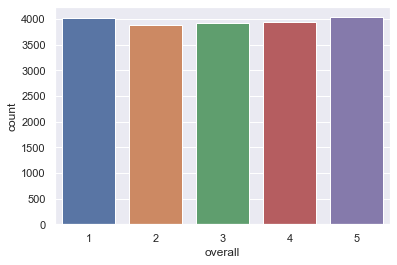

In [8]:
sns.countplot(x='overall', data=df)
plt.show()

In [9]:
# Getting read of reviews that include information about the number of stars or 
# those below 6 words
war_1 = df.reviewText.str.contains('one star')
war_2 = df.reviewText.str.contains('two star')
war_3 = df.reviewText.str.contains('three star')
war_4 = df.reviewText.str.contains('four star')
war_5 = df.reviewText.str.contains('five star')
war_6 = (df.reviewText.str.split().str.len() > 5)

mask = (~war_1 & ~war_2 & ~war_3 & ~war_4 & ~war_5 & war_6)
df = df[mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12242 entries, 1 to 19807
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   overall     12242 non-null  int16         
 1   vote        12242 non-null  int64         
 2   reviewTime  12242 non-null  datetime64[ns]
 3   reviewText  12242 non-null  object        
 4   summary     12242 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(1), object(2)
memory usage: 502.1+ KB


## Baseline Model

In [10]:
X = df['reviewText']
y = df['overall']-1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
# creating tfidf model
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [13]:
print('Vocabulary Size: ', len(tfidf.get_feature_names()))

Vocabulary Size:  494


In [14]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=20)
gb.fit(X_train_tfidf, y_train)
gb.score(X_test_tfidf, y_test)

0.3344222131482238

In [15]:
y_test_pred_gb = gb.predict(X_test_tfidf)

In [16]:
cl_report_gb = pd.DataFrame(classification_report(y_test, y_test_pred_gb, output_dict=True)).T
display(cl_report_gb)

,precision,recall,f1-score,support
0,0.447080,0.467557,0.457090,524.000000
1,0.289298,0.336576,0.311151,514.000000
2,0.266294,0.280392,0.273161,510.000000
3,0.303614,0.266385,0.283784,473.000000
4,0.376068,0.308411,0.338896,428.000000
accuracy,0.334422,0.334422,0.334422,0.334422
macro avg,0.336471,0.331864,0.332816,2449.000000
weighted avg,0.336197,0.334422,0.334029,2449.000000


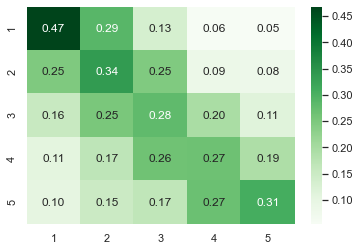

In [17]:
cm_gb = confusion_matrix(y_test, y_test_pred_gb, normalize='true')
sns.heatmap(cm_gb, cmap='Greens',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

## Hyperparameter Tuning
## Informed Search - Coarse to Fine 
### Randomized Search to Grid Search

In [18]:
# Creating Pipeline

steps = [('vectorizer', TfidfVectorizer()),
         ('classifier', GradientBoostingClassifier())]

pipe = Pipeline(steps)

In [19]:
params = {#'vectorizer': [TfidfVectorizer(), CountVectorizer()],
          'vectorizer__max_df':[0.8,0.9,0.99,1.],
          'vectorizer__min_df':[0.001, 0.01, 0.],
          'vectorizer__max_features':[1_000, 10_000],
          'vectorizer__ngram_range':[(1,1),(1,2)],
          #'classifier': [RandomForestClassifier(), GradientBoostingClassifier()],
          'classifier__n_estimators':[100,200,500],
          'classifier__max_depth':[5,8,10,20,50,100],
          'classifier__max_features':[0.4,0.6,0.8,1.],
          'classifier__subsample':[0.4,0.6,0.8,1.]
           }

In [20]:
search = RandomizedSearchCV(pipe, 
                            param_distributions=params,
                            n_iter=20,
                            cv=3)